# データの取得方法

ここではQuandl.comからのデータを受け取っています。今回入手した日経平均株価は、
時間、開始値、最高値、最低値、終値のデータを入手していますが、古いデータは終値しかないようですので、終値を用います。
*** TODO いつからデータを入手することが最も効果的かを考える。（処理時間と制度に影響が出るため）

In [1]:
import quandl
data = quandl.get('NIKKEI/INDEX')

In [2]:
data[:5]

,Open Price,High Price,Low Price,Close Price
Date,,,,
1950-01-04,NaN,NaN,0.0,108.56
1950-01-05,NaN,NaN,0.0,105.54
1950-01-06,NaN,NaN,0.0,102.64
1950-01-09,NaN,NaN,0.0,102.78
1950-01-10,NaN,NaN,0.0,101.36


In [41]:
data_normal = (((data['Close Price']).to_frame())[-10000:-1])['Close Price']
data_normal[-10:-1] # 最新のデータ１０件を表示

Date
2017-07-21    20099.75
2017-07-24    19975.67
2017-07-25    19955.20
2017-07-26    20050.16
2017-07-27    20079.64
2017-07-28    19959.84
2017-07-31    19925.18
2017-08-01    19985.79
2017-08-02    20080.04
Name: Close Price, dtype: float64

抜けデータが目立ったため、週単位でのデータを入手します

In [42]:
data_normal = data_normal.resample('W-MON').fillna(method='pad')

In [43]:
data_normal[:5]

Date
1977-02-07    5078.75
1977-02-14    4979.03
1977-02-21    5023.52
1977-02-28    5079.11
1977-03-07    5034.52
Freq: W-MON, Name: Close Price, dtype: float64

In [44]:
type(data_normal.index[0])
data_normal.index

DatetimeIndex(['1977-02-07', '1977-02-14', '1977-02-21', '1977-02-28',
               '1977-03-07', '1977-03-14', '1977-03-21', '1977-03-28',
               '1977-04-04', '1977-04-11',
               ...
               '2017-06-05', '2017-06-12', '2017-06-19', '2017-06-26',
               '2017-07-03', '2017-07-10', '2017-07-17', '2017-07-24',
               '2017-07-31', '2017-08-07'],
              dtype='datetime64[ns]', name='Date', length=2114, freq='W-MON')

# データの用い方

必要となるpythonパッケージのインポートを行っています。
*** TODO 実装はClojureで行いため、これに相当するパッケージを検索、作成を行う

In [45]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas.core import datetools
# grapgh plotting 
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# settings graph size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# model 
import statsmodels.api as sm

以下のグラフから、2000年ごろのデータからの推測でも十分に予測が行える可能性が伺えます。

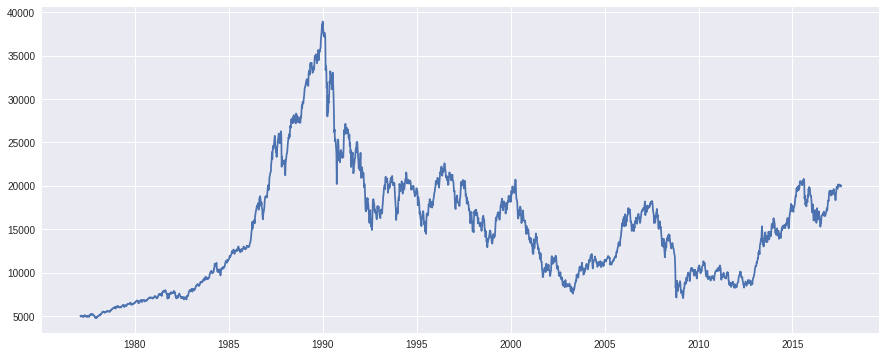

In [46]:
plt.plot(data_normal)

ARIMAモデルでモデル推定を行うための下準備として、株価の変化量を取得します。

In [47]:
# ARIMA model prediction ... (This is self thought (not automatically))
diff = data_normal - data_normal.shift()
diff = diff.dropna()
diff.head()

Date
1977-02-14   -99.72
1977-02-21    44.49
1977-02-28    55.59
1977-03-07   -44.59
1977-03-14   -71.92
Freq: W-MON, Name: Close Price, dtype: float64

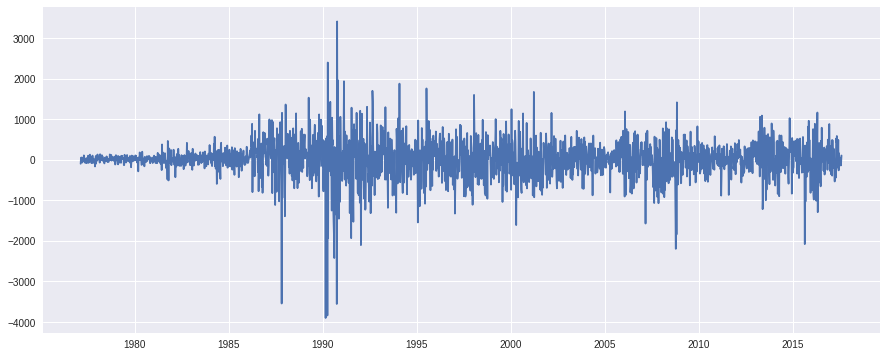

In [48]:
# difference plot 
plt.plot(diff)

AICを求めてモデルの良さを計算しますが、やや時間（約三分）がかかってしまします。
（SARIMAモデルでこれを行うと、更に時間がかかります）
*** TODO 実行時間の計測と最適化・マシンスペックの向上と性能の関係の調査

In [49]:
# automatically ARIMA prediction function (using AIC)
resDiff = sm.tsa.arma_order_select_ic(diff, ic='aic', trend='nc')
# few Times ...(orz...)

先程の実行結果から、AR=2, MA=2という値の場合が最も良いモデルになることがわかりました。

In [51]:
resDiff 
# search min
resDiff['aic_min_order']

(2, 2)

### 比較のためSARIMAモデルではなく、ARIMAモデルでの推定を行ってみます。

こちらの実行はそれほど時間がかかりません。

In [52]:
# we found x = x, y= y autopmatically
from statsmodels.tsa.arima_model import ARIMA
ARIMAx_1_y = ARIMA(data_normal, 
                  order=(resDiff['aic_min_order'][0], 1,
                  resDiff['aic_min_order'][1])).fit(dist=False)
# AR = resDiff[...][0] / I = 1 / MA = resDiff[...][1]
ARIMAx_1_y.params

const                  7.087161
ar.L1.D.Close Price   -1.690125
ar.L2.D.Close Price   -0.931886
ma.L1.D.Close Price    1.633455
ma.L2.D.Close Price    0.885898
dtype: float64

予測のブレがあまりないことが伺えます

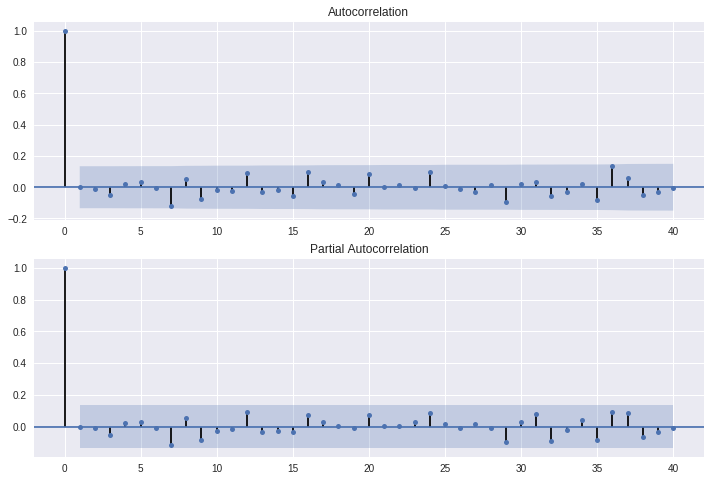

In [34]:
# check Residual error (... I think this is "White noise")
# this is not Arima ... (Periodicity remained)
resid = ARIMAx_1_y.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# ok? 

In [ ]:
# We test SARIMA_model

### SARIMAモデルでの推定を行ってみます。

ARIMAモデルの実行がそれほど時間がかからなかったのに対して、SARIMAモデルはやや時間がかかること、Wariningが出ることが難点です。

In [54]:
# predict SARIMA model  by  myself (not automatically) 
import statsmodels.api as sm

SARIMAx_1_y_111 = sm.tsa.SARIMAX(data_normal, 
                                 order=(2,1,2),seasonal_order=(1,1,1,12)).fit()
# order ... from ARIMA model // seasonal_order ... 1 1 1 ... ?  
print(SARIMAx_1_y_111.summary())

# maybe use "Box-Jenkins method" ...
# https://github.com/statsmodels/statsmodels/issues/3620 for error

                                 Statespace Model Results                                 
Dep. Variable:                        Close Price   No. Observations:                 2114
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood              -15992.746
Date:                            Sat, 05 Aug 2017   AIC                          31999.492
Time:                                    11:19:48   BIC                          32039.086
Sample:                                02-07-1977   HQIC                         32013.989
                                     - 08-07-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0047    242.738  -1.96e-05      1.000    -475.762     475.752
ar.L2          0.9952    256.052   

おおよそ見た限りではARIMAモデルと大差はないようですが、他の論文を読む限りではこちらの手法のほうが推測が上手く行くようです。
*** TODO データを少なくした場合の実行結果

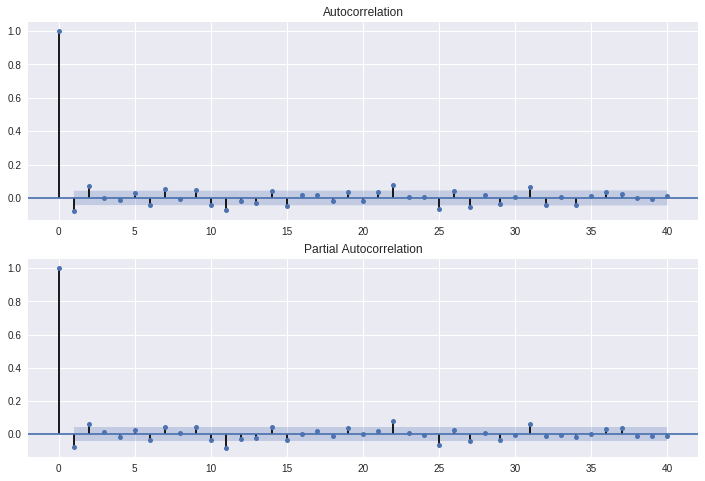

In [55]:
# check Residual error
residSARIMA = SARIMAx_1_y_111.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)

In [56]:
# prediction
pred = SARIMAx_1_y_111.predict('2015-01-05','2018-01-15')
print(pred)
(print(SARIMAx_1_y_111.__doc__))

# 本来は未来（インデクスの外）まで予測ができるはずなのですが、
# 何故かエラーが出てしまうので、既存のデータ部分だけ予測します

# TODO エラーの原因特定

2015-01-05    17747.738160
2015-01-12    17427.771284
2015-01-19    17231.481124
2015-01-26    17074.573197
2015-02-02    17456.428858
2015-02-09    17619.333963
2015-02-16    17695.585205
2015-02-23    18026.227951
2015-03-02    18508.288043
2015-03-09    18801.811764
2015-03-16    18810.224735
2015-03-23    19204.765300
2015-03-30    19772.236807
2015-04-06    19436.651779
2015-04-13    19413.273450
2015-04-20    19958.607410
2015-04-27    19624.143471
2015-05-04    20038.139608
2015-05-11    19530.683862
2015-05-18    19639.691153
2015-05-25    19948.814803
2015-06-01    20393.446114
2015-06-08    20605.149584
2015-06-15    20421.996593
2015-06-22    20416.546901
2015-06-29    20441.350890
2015-07-06    20164.661474
2015-07-13    20131.201743
2015-07-20    20099.464699
2015-07-27    20674.795954
                  ...     
2017-06-26    19971.449063
2017-07-03    20220.724352
2017-07-10    19937.000323
2017-07-17    20183.758180
2017-07-24    20091.633265
2017-07-31    20082.369424
2

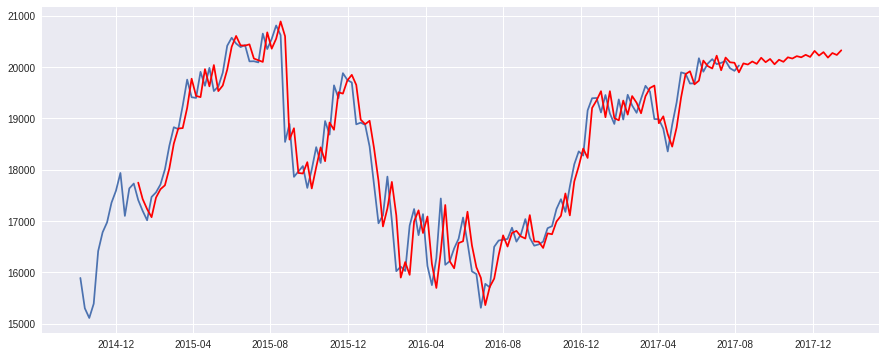

In [60]:
# plot real data and predict data 
plt.plot(data_normal[:-150:-1])
plt.plot(pred, "r")

青が実測値、赤が予測値です。それに近い値を計測できたのではないでしょうか？

# ランダムフォレストによる欠損値補完